In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def non_max_suppression(boxes, scores, threshold):
    """
    Perform non-maximum suppression on bounding boxes.

    Parameters:
    - boxes: List of bounding boxes [x_min, y_min, x_max, y_max].
    - scores: List of confidence scores.
    - threshold: Overlapping threshold for non-maximum suppression.

    Returns:
    - selected_indices: Indices of selected bounding boxes after NMS.
    """
    selected_indices = []

    # Sort bounding boxes by confidence score (in descending order)
    order = np.argsort(scores)[::-1]

    while len(order) > 0:
        # Select the box with the highest confidence score
        index = order[0]
        selected_indices.append(index)

        # Calculate overlap with other boxes
        overlap = calculate_overlap(boxes[index], boxes[order[1:]])

        # Remove boxes with overlap greater than the threshold
        order = order[1:][overlap <= threshold]

    return selected_indices

def calculate_overlap(box, boxes):
    """
    Calculate the overlap (IoU) between a box and a list of boxes.

    Parameters:
    - box: Bounding box [x_min, y_min, x_max, y_max].
    - boxes: List of bounding boxes.

    Returns:
    - overlap: Overlap values.
    """
    x_min = np.maximum(box[0], boxes[:, 0])
    y_min = np.maximum(box[1], boxes[:, 1])
    x_max = np.minimum(box[2], boxes[:, 2])
    y_max = np.minimum(box[3], boxes[:, 3])

    intersection = np.maximum(0, x_max - x_min) * np.maximum(0, y_max - y_min)
    area_box = (box[2] - box[0]) * (box[3] - box[1])
    area_boxes = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union = area_box + area_boxes - intersection

    overlap = intersection / union
    return overlap


def nms(boxes, threshold = 0.5):
    # pred_string = df['PredictionString']
    # boxes = pred_string[0][:-1].split(" ")
    # boxes = [boxes[i:i+6] for i in range(0, len(boxes), 6)]
    classes = np.array([int(item[0]) for item in boxes])
    confidences = np.array([float(item[1]) for item in boxes])
    bboxes = np.array([[float(item[2]), float(item[3]), float(item[4]), float(item[5])] for item in boxes])

    selected_indices = non_max_suppression(bboxes, confidences, threshold)
    # print(selected_indices)
    selected_boxes = [boxes[i] for i in selected_indices]
    # print(len(selected_boxes))
    # for index in selected_indices:
    #     print(boxes[index])
    return selected_boxes
    

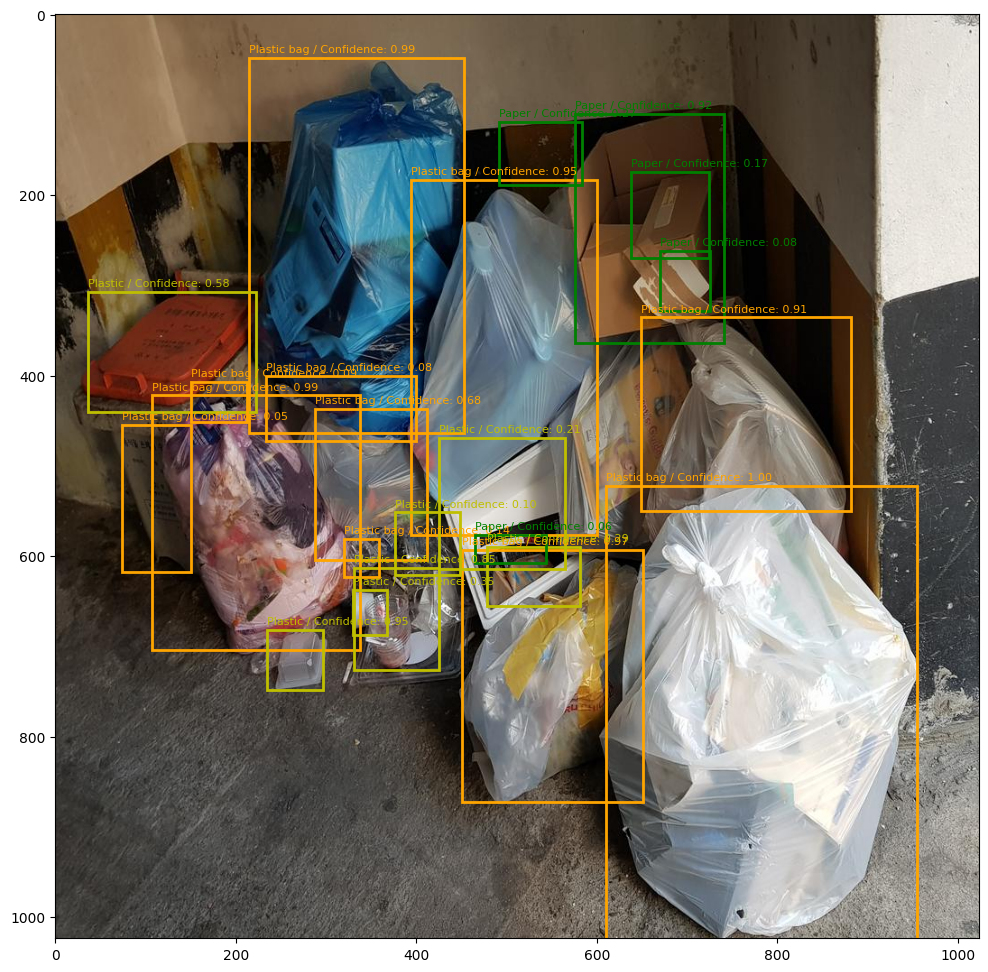

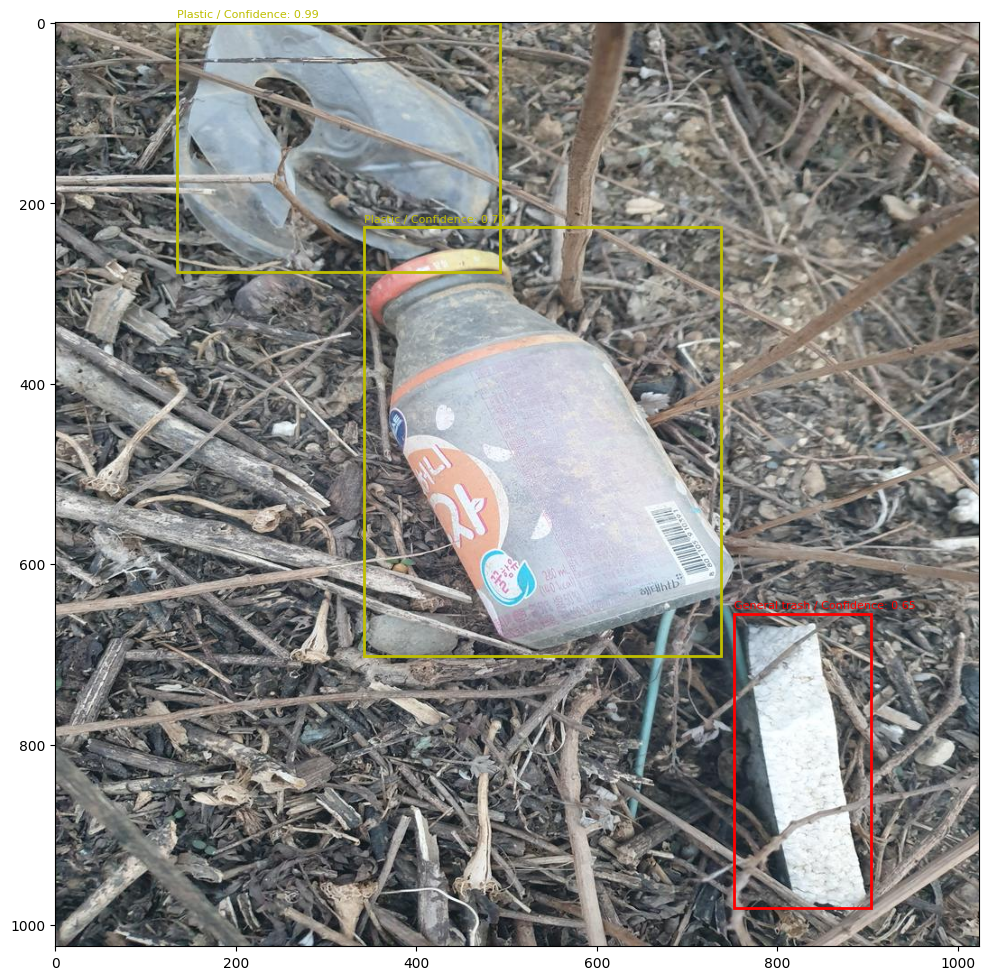

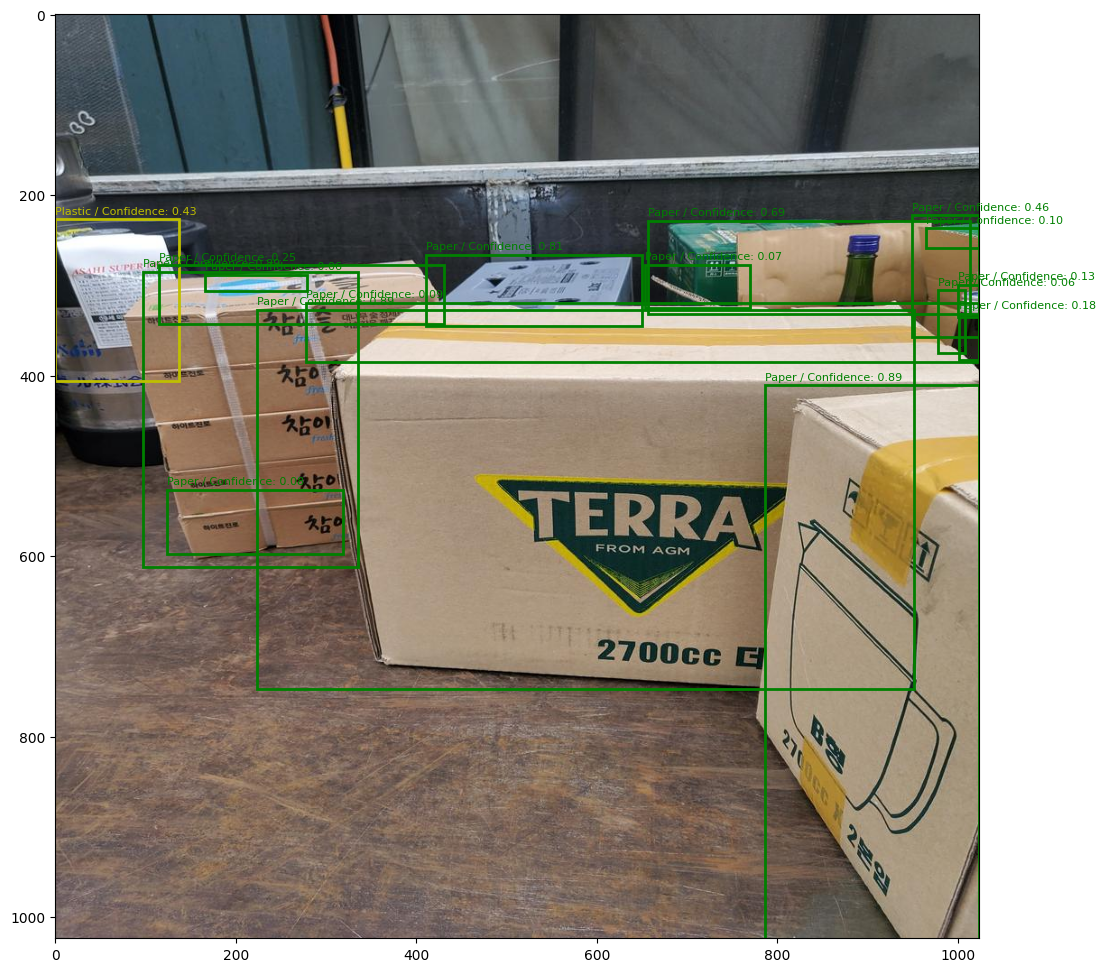

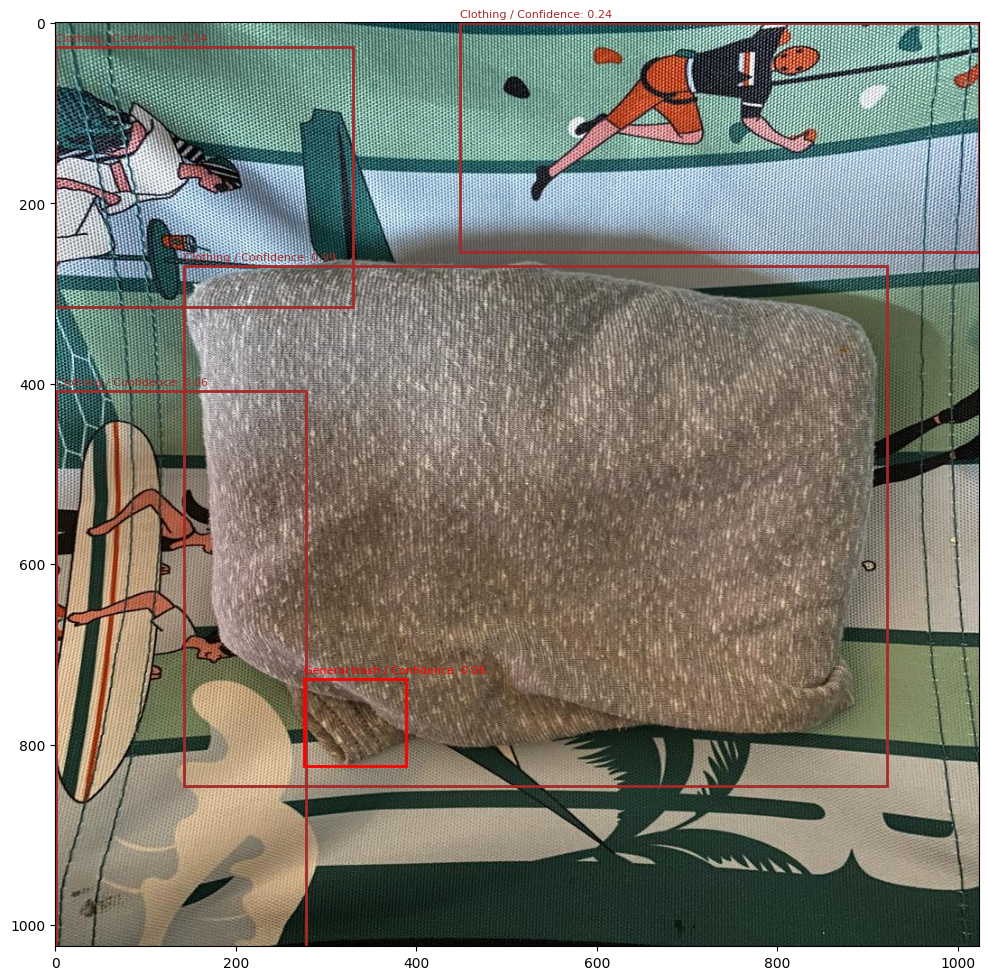

KeyboardInterrupt: Interrupted by user

In [2]:
# 제출파일을 Visualize해서 눈으로 검증하는 파일

df = pd.read_csv('/data/ephemeral/home/code/mmdetection/work_dirs/casacade_swinvL_AdamW_kfold2/20240118_114958/submit/submission.csv')
data_dir = '/data/ephemeral/home/data/dataset/'
nms_threshhold = 0.2
class_confidence_threshhold = 0.05
class_mapping = {
    0: ('General trash', 'r'),
    1: ('Paper', 'g'),
    2: ('Paper pack', 'b'),
    3: ('Metal', 'c'),
    4: ('Glass', 'm'),
    5: ('Plastic', 'y'),
    6: ('Styrofoam', 'k'),
    7: ('Plastic bag', 'orange'),
    8: ('Battery', 'purple'),
    9: ('Clothing', 'brown'),
}
# Function to plot images with bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Open the image
    img = Image.open(data_dir + image_path)

    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(15, 12))

    # Display the image
    ax.imshow(img)

    boxes = nms(boxes, threshold=nms_threshhold)

    # Add bounding boxes
    for box in boxes:
        class_number, class_confidence, x_min, y_min, x_max, y_max = box
        class_number, class_confidence, x_min, y_min, x_max, y_max = int(class_number), float(class_confidence), float(x_min), float(y_min), float(x_max), float(y_max)
        box_width = x_max - x_min
        box_height = y_max - y_min
        class_label, box_color = class_mapping.get(class_number, ('Unknown', 'gray'))
        if class_confidence < class_confidence_threshhold:
            continue

        if class_label == 'Unknown':
            continue

        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x_min, y_min),
            box_width,
            box_height,
            linewidth=2,
            edgecolor=box_color,
            facecolor='none',
            label=f'{class_label} - Confidence: {class_confidence:.2f}'
        )
        ax.text(x_min, y_min - 15, f'{class_label} / Confidence: {class_confidence:.2f}', color=box_color, fontsize=8, va='top')
        # Add the patch to the Axes
        ax.add_patch(rect)
        
    # ax.legend()
    # Show the plot without blocking
    plt.show(block=False)
# Iterate through unique image IDs and plot the images with bounding boxes
for image_id in df['image_id'].unique():
    image_df = df[df['image_id'] == image_id]
    boxes = image_df['PredictionString'].iloc[0].split(' ')[:-1]
    
    boxes = [boxes[i:i+6] for i in range(0, len(boxes), 6)]
    image_path = image_df['image_id'].iloc[0]

    plot_image_with_boxes(image_path, boxes)

    # Pause for user input (press any key to show the next image)
    plt.pause(0.001)
    input("Press Enter to show the next image...")

# Close the plot at the end
plt.close()

In [37]:
# CSV를 합치는 프로그램

import os
import pandas as pd

def nan_to_blank(value):
    return str(value) if not pd.isna(value) else ''

csv_dir_path = '/data/ephemeral/home/code/mmdetection/vis_annotate_data'
submissions = []
for file_name in os.listdir(csv_dir_path):
    file_path = os.path.join(csv_dir_path, file_name)
    if os.path.isfile(file_path):
        submissions.append(file_path)

dfs = [pd.read_csv(submission) for submission in submissions]

result_df = dfs[0]
result_df['PredictionString'] = result_df['PredictionString'].map(lambda x: nan_to_blank(x))
dfs = dfs[1:]

for df in dfs:
    df['PredictionString'] = df['PredictionString'].map(lambda x: nan_to_blank(x))
    result_df['PredictionString'] = result_df['PredictionString'].map(str) + df['PredictionString'].map(str)

result_df.to_csv(os.path.join(csv_dir_path, 'ensembled.csv'), index=False)

In [4]:
# 제출 CSV파일에 대해 검증하는 파일

import os
import pandas as pd

result_df = pd.read_csv('output_failed.csv')

result_df.head()

for image_id in result_df['image_id'].unique():
    image_df = result_df[result_df['image_id'] == image_id]
    boxes = image_df['PredictionString'].iloc[0].split(' ')[:-1]
    boxes = [boxes[i:i+6] for i in range(0, len(boxes), 6)]
    
    for box in boxes:
        assert len(box[0]) == 1, f'{box}의 클래스 길이가 이상합니다. 이미지 아이디는 {image_id}'
        assert float(box[1]) < 1 or float(box[1]) > 0, f'{box}의 confidence scoreRK 이상합니다. 이미지 아이디는 {image_id}'
        assert len(box) == 6, f'박스 길이가 이상해요 이미지 아이디는 {image_id}'

IndexError: single positional indexer is out-of-bounds

In [16]:
# 특정 제출 파일에 대해 nms와 confidence score filtering 을 하는 기능

import pandas as pd

data_dir = '/data/ephemeral/home/data/dataset/'
nms_threshold = 0.4
class_confidence_threshhold = 0.2
submission = '/data/ephemeral/home/code/mmdetection/vis_annotate_data/ensembled.csv'
df = pd.read_csv(submission).astype({'PredictionString': str})

for image_id in df['image_id'].unique():
    image_df = df[df['image_id'] == image_id]
    boxes = image_df['PredictionString'].iloc[0].split(' ')[:-1]
    boxes = [boxes[i:i+6] for i in range(0, len(boxes), 6)]
    
    nms_boxes = nms(boxes, nms_threshhold)
    confidence_filtered_boxes = [box for box in boxes if float(box[1]) > class_confidence_threshhold]

    box_string = ' '.join([' '.join(box) for box in confidence_filtered_boxes]) + ' '
    df.at[image_df.index[0], 'PredictionString'] = box_string

df.to_csv('/data/ephemeral/home/code/mmdetection/vis_annotate_data/ensembled_nms.csv', index=False)


ValueError: could not convert string to float: ''